In [1]:
import sqlite3, json
import pandas as pd
import subprocess as spc
import dateparser

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# #export CC databases
# spc.run("curl 'https://craftcollectivedist.com/ECP_19.12_A/aspx1/Home.aspx?ParseFromReportURL=True&ReportID=5062127&ReportName=CUSTOMERS_XLSX' -H 'authority: craftcollectivedist.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' -H 'sec-fetch-site: same-origin' -H 'sec-fetch-mode: navigate' -H 'referer: https://craftcollectivedist.com/ECP_19.12_A/aspx1/SavedReports.aspx?' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: EncompassDistributor=CraftCollect; EncompassDBServer=MySQL12; EncompassSessionID=17bbb91f5e21b866fe9b853c0faf3bfc; EncompassGuestDashboardID=147731; Email=ben@fab.beer; MenuCollapsed=False; ExpireTime=1578200455484' --compressed > customers.xslx",
#                         shell=True, stdout=spc.PIPE)
# spc.run("curl 'https://craftcollectivedist.com/ECP_19.12_A/aspx1/Home.aspx?ParseFromReportURL=True&ReportID=5062129&ReportName=CUSTOMER_HISTORY_XSLX' -H 'authority: craftcollectivedist.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' -H 'sec-fetch-site: same-origin' -H 'sec-fetch-mode: navigate' -H 'referer: https://craftcollectivedist.com/ECP_19.12_A/aspx1/SavedReports.aspx?' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: EncompassDistributor=CraftCollect; EncompassDBServer=MySQL12; EncompassSessionID=17bbb91f5e21b866fe9b853c0faf3bfc; EncompassGuestDashboardID=147731; Email=ben@fab.beer; MenuCollapsed=False; ExpireTime=1578200455484' --compressed > customer_history.xslx",
#                         shell=True, stdout=spc.PIPE)

# #generate PD dataframes
# CUSTOMERS_DF = pd.read_excel("customers.xslx")
# CUSTOMER_HISTORY_DF = pd.read_excel("customer_history.xslx")

In [13]:
#IMPORT UNTAPPD DATAFRAME
conn = sqlite3.connect("untappd.db")
df = pd.read_sql_query("select * from checkins;", conn)
jsons  = df.json.apply(lambda j: json.loads(j))
CHECKINS_DF = pd.DataFrame(jsons.apply(lambda x: pd.Series(x)))
CHECKINS_DF["purchased"] = df["purchased"]

def expand(df, key):
    return df.apply(lambda x:pd.concat([x,pd.Series(list(x[key].values()),index=[(f"{key}_{k}" if not key in k else k ) for k in list(x[key].keys())]) if type(x[key])==dict else None]) , axis = 1).drop(key,axis="columns")
expanded = expand(expand(expand(expand(CHECKINS_DF,"venue"),"beer"),"brewery"),"venue_location")

expanded["created_date"] = expanded.created_at.apply(lambda x: dateparser.parse(x))
expanded["created_day"] = expanded["created_date"].apply(lambda x: x.timestamp()/3600//24)
expanded["created_week"] = expanded["created_date"].apply(lambda x: x.timestamp()/3600/24//7)
with_ratings = expanded.loc[expanded.rating_score > 0]

In [14]:
%matplotlib inline

In [15]:
df

,cid,timestamp,beer,venue,json,purchased
0,953341972,1602713529,Cosmic Plankton,Untappd at Home,"{""checkin_id"": 953341972, ""created_at"": ""Wed, ...",/v/gold-star-beer-counter/3171446
1,953343161,1602713743,Johnny Get Your Ray Gun ... #fabraygun,Untappd at Home,"{""checkin_id"": 953343161, ""created_at"": ""Wed, ...",/v/kent-haxton-s-liquor/2636417
2,953359908,1602716651,Atlantis Will Prevail ... #fabatlantis,Untappd at Home,"{""checkin_id"": 953359908, ""created_at"": ""Wed, ...",
3,953362324,1602717038,Johnny Get Your Ray Gun ... #fabraygun,Untappd at Home,"{""checkin_id"": 953362324, ""created_at"": ""Wed, ...",/v/kent-haxton-s-liquor/2636417
4,953363112,1602717158,"Squid 3D (Citra, Mosaic & Centennial)",,"{""checkin_id"": 953363112, ""created_at"": ""Wed, ...",/v/decicco-s/8970245
...,...,...,...,...,...,...
320,958451931,1603933001,Atlantis Will Prevail ... #fabatlantis,Untappd at Home,"{""checkin_id"": 958451931, ""created_at"": ""Thu, ...",
321,958472228,1603937779,Fab 200 Days ... #fab200,,"{""checkin_id"": 958472228, ""created_at"": ""Thu, ...",
322,958481688,1603941234,Johnny Get Your Ray Gun ... #fabraygun,,"{""checkin_id"": 958481688, ""created_at"": ""Thu, ...",
323,958503914,1603972654,Cosmic Plankton,Untappd at Home,"{""checkin_id"": 958503914, ""created_at"": ""Thu, ...",


In [16]:
CHECKINS_DF

,checkin_id,created_at,checkin_comment,rating_score,user,beer,brewery,venue,comments,toasts,media,source,badges,purchased
0,953341972,"Wed, 14 Oct 2020 22:12:09 +0000",Tasty and tart,4.00,"{'uid': 4056474, 'user_name': 'WScher', 'first...","{'bid': 3999010, 'beer_name': 'Cosmic Plankton...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...","{'venue_id': 9917985, 'venue_name': 'Untappd a...","{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 0, 'count': 0, 'auth_toast': F...","{'count': 1, 'items': [{'photo_id': 322669821,...","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 4, 'items': [...",/v/gold-star-beer-counter/3171446
1,953343161,"Wed, 14 Oct 2020 22:15:43 +0000",Not my favorite but I liked the cans!,2.25,"{'uid': 5143151, 'user_name': 'J-aaahhh', 'fir...","{'bid': 3684332, 'beer_name': 'Johnny Get Your...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...","{'venue_id': 9917985, 'venue_name': 'Untappd a...","{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 0, 'count': 0, 'auth_toast': F...","{'count': 1, 'items': [{'photo_id': 322670376,...","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 3, 'items': [...",/v/kent-haxton-s-liquor/2636417
2,953359908,"Wed, 14 Oct 2020 23:04:11 +0000",,4.50,"{'uid': 2680344, 'user_name': 'Vincemckenzie',...","{'bid': 3703391, 'beer_name': 'Atlantis Will P...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...","{'venue_id': 9917985, 'venue_name': 'Untappd a...","{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 0, 'count': 0, 'auth_toast': F...","{'count': 0, 'items': []}","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 5, 'items': [...",
3,953362324,"Wed, 14 Oct 2020 23:10:38 +0000",Pure hops. Strongly recommended.,4.50,"{'uid': 68052, 'user_name': 'majeikstagram', '...","{'bid': 3684332, 'beer_name': 'Johnny Get Your...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...","{'venue_id': 9917985, 'venue_name': 'Untappd a...","{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 1, 'count': 1, 'auth_toast': N...","{'count': 1, 'items': [{'photo_id': 322678816,...","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 1, 'items': [...",/v/kent-haxton-s-liquor/2636417
4,953363112,"Wed, 14 Oct 2020 23:12:38 +0000",,3.75,"{'uid': 209388, 'user_name': 'Quinnk285', 'fir...","{'bid': 3998726, 'beer_name': 'Squid 3D (Citra...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...",[],"{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 1, 'count': 1, 'auth_toast': N...","{'count': 0, 'items': []}","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 2, 'items': [...",/v/decicco-s/8970245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,958451931,"Thu, 29 Oct 2020 00:56:41 +0000",Dank. Juicy. Dry. Grapefruit. Its FAB! Fridge ...,4.00,"{'uid': 227310, 'user_name': 'mrsteeb', 'first...","{'bid': 3703391, 'beer_name': 'Atlantis Will P...","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...","{'venue_id': 9917985, 'venue_name': 'Untappd a...","{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 13, 'count': 9, 'auth_toast': ...","{'count': 1, 'items': [{'photo_id': 325212925,...","{'app_name': 'Untappd for Android - (V2)', 'ap...","{'retro_status': False, 'count': 2, 'items': [...",
321,958472228,"Thu, 29 Oct 2020 02:16:19 +0000",,3.00,"{'uid': 8167192, 'user_name': 'ptrckjohnson', ...","{'bid': 3935598, 'beer_name': 'Fab 200 Days .....","{'brewery_id': 451812, 'brewery_name': 'FAB Fe...",[],"{'total_count': 0, 'count': 0, 'items': []}","{'total_count': 0, 'count': 0, 'auth_toast': F...","{'count': 1, 'items': [{'photo_id': 325221649,...","{'app_name': 'Untappd for iPhone - (V2)', 'app...","{'retro_status': False, 'count': 3, 'items': [...",
322,958481688,"Thu, 29 Oct 2020 03:13:54 +0000",,4.00,"{'uid': 2278666, 'user_name': 'russellhasnonam...","{

<AxesSubplot:title={'center':'average untappd score across all brands'}, xlabel='created_day', ylabel='rating_score'>

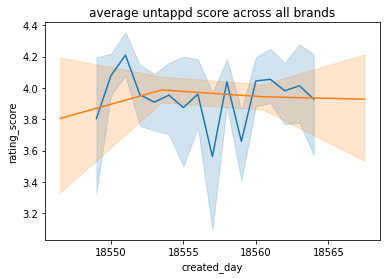

In [17]:
f = plt.gcf()
plt.gca().set_title("average untappd score across all brands")
sns.lineplot(x = "created_day", y="rating_score", data = with_ratings)
sns.lineplot(x = with_ratings.created_week*7+3.5, y="rating_score", data = with_ratings)

In [18]:
with_ratings.groupby("purchased").size()

purchased
                                                            213
/v/209-station/3732118                                        1
/v/art-s-specialities/7451783                                 1
/v/aurora-brew-works/309500                                   1
/v/beer-garden-worcester/8251165                              2
                                                           ... 
/v/underground-coffee-and-ales/3067559                        1
/v/vinal-square-craft-beer-house-premium-liquors/5649542      1
/v/wangs-liquors/7646857                                      1
/v/wines-more-mansfield/235957                                1
/v/wines-more-wareham/293507                                  1
Length: 64, dtype: int64

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


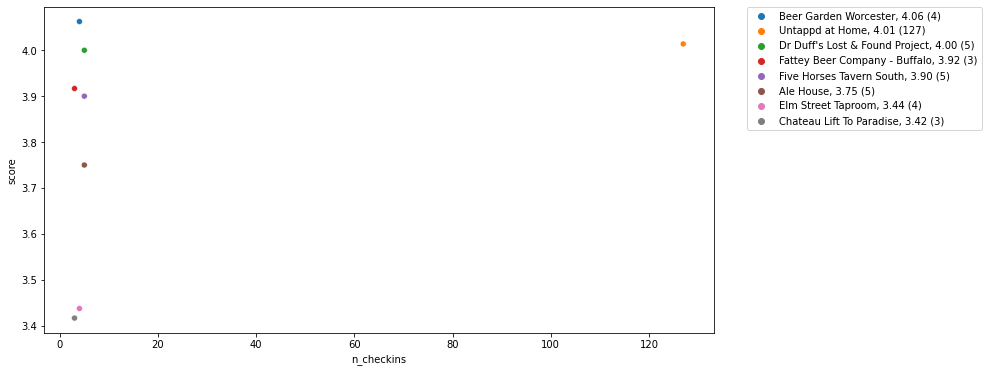

In [19]:
plt.figure()
plt.gcf().set_size_inches(12,6)
out = pd.concat([with_ratings.groupby("venue_name").size().rename("n_checkins"),
           with_ratings.groupby("venue_name").rating_score.mean().sort_values().rename("score")],
          axis=1, sort =True).sort_values("score",ascending=False)
out.index.name="venue_name"
out = out.reset_index().loc[lambda x: x.n_checkins>2]

sns.scatterplot("n_checkins","score", hue = out.apply(lambda x:f'{x.venue_name}, {x.score:.2f} ({x.n_checkins})',axis=1) , data = out)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
beer_counts = 

<AxesSubplot:title={'center':'average ratings by week'}, xlabel='created_week', ylabel='rating_score'>

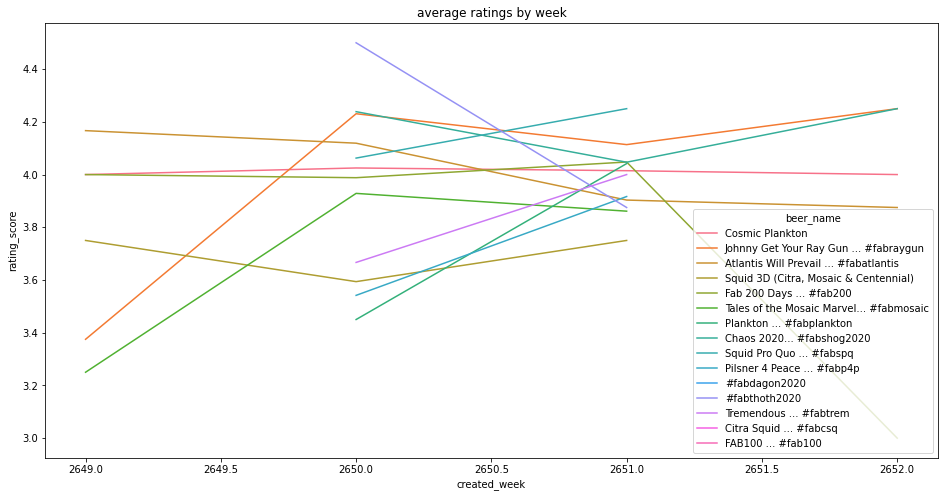

In [29]:
f,subs = plt.subplots(1,1)
f.set_size_inches(16,8)

plt.sca(subs)
plt.gca().set_title("average ratings by week")
sns.lineplot(x = "created_week", y="rating_score", hue = "beer_name", ci=None, data = with_ratings)


# plt.sca(subs[1])
# plt.gca().set_title("all ratings")
# sns.scatterplot(x = "created_day", y="rating_score",hue="beer_bid", data = with_ratings)

<AxesSubplot:title={'center':'counts of checkins by week'}, xlabel='created_week', ylabel='count'>

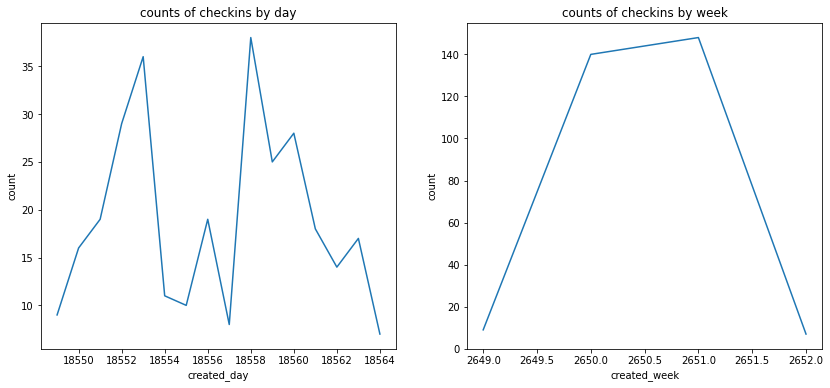

In [31]:
f,subs = plt.subplots(1,2)
f.set_size_inches(14,6)

plt.sca(subs[0])
plt.gca().set_title("counts of checkins by day")
sns.lineplot(x="created_day", y="count",data =  with_ratings.groupby(["created_day"]).size().rename("count").reset_index())

plt.sca(subs[1])
plt.gca().set_title("counts of checkins by week")
sns.lineplot(x="created_week", y="count",data =  with_ratings.groupby(["created_week"]).size().rename("count").reset_index())

